### Run, train and validate DNN (Keras Model)

Pre-process the data, train and validate models using AUC as the performance metric

In [1]:
import tensorflow as tf
import pandas as pd

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,
    HyperparameterTuner,
)

role = get_execution_role()
session = sagemaker.Session()
sklearn_v = "0.20.0"

import tf_model_input_prep
import plot_hyperparameter_tuning as plt_hyper
import evaluate_keras_model as evaluate

In [2]:
# create a list of the features to use for modeling

feat_list = [
    "CUST_PRICE_SENSITIVITY",
    "CUST_LIFESTAGE",
    "BASKET_SIZE_PROP_SPEND_PROD_CODE_M",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA",
    "DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON",
    "BASKET_SIZE_PROP_VISITS_CUST_CODE_L",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh",
    "BASKET_TYPE_PROP_VISITS_CUST_CODE_Small Shop",
    "BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_MS",
    "CHNG_VISITS_PROD_CODE_30_1_52",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_LS",
    "STORE_FORMAT_PROP_QUANTITY_CUST_CODE_SS",
    "BASKET_SIZE_QUANTITY_CUST_CODE_S",
    "BASKET_DOMINANT_MISSION_PROP_QUANTITY_PROD_CODE_Nonfood",
    "CHNG_SPEND_PROD_CODE_40_8_52",
    "BASKET_DOMINANT_MISSION_PROP_VISITS_CUST_CODE_XX",
    "BASKET_TYPE_VISITS_CUST_CODE_XX",
    "WKDAY_WKEND_PROP_QUANTITY_CUST_CODE_WEEKEND",
    "BASKET_TYPE_QUANTITY_CUST_CODE_Small Shop",
    "SPEND_PROD_CODE_30_52",
    "BASKET_TYPE_SPEND_CUST_CODE_Top Up",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_CUST_CODE_Grocery",
    "CHNG_QUANTITY_PROD_CODE_40_26_52",
    "SPEND_PROD_CODE_20_52",
    "BASKET_TYPE_PROP_QUANTITY_CUST_CODE_Top Up",
    "VISITS_PROD_CODE_20_52",
    "WKDAY_WKEND_PROP_VISITS_PROD_CODE_WEEKEND",
    "VISITS_PROD_CODE_40_1",
    "CHNG_VISITS_PROD_CODE_40_1_26",
    "BASKET_TYPE_PROP_SPEND_PROD_CODE_XX",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_XLS",
    "DAY_PART_PROP_VISITS_CUST_CODE_EVENING",
    "TIME_BTWN_MEDIAN_OVERALL_PROD_CODE_40",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_XLS",
    "DAY_PART_PROP_SPEND_PROD_CODE_MORNING",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_SS",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_MS",
    "DAY_PART_PROP_SPEND_CUST_CODE_MORNING",
    "BASKET_PRICE_SENSITIVITY_PROP_SPEND_PROD_CODE_LA",
    "DAY_PART_PROP_QUANTITY_PROD_CODE_EVENING",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_UM",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Grocery",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_PROD_CODE_MM",
    "STORE_FORMAT_PROP_SPEND_CUST_CODE_LS",
    "QUANTITY_PROD_CODE_52",
    "BASKET_TYPE_PROP_VISITS_PROD_CODE_Top Up",
    "DAY_PART_PROP_SPEND_PROD_CODE_AFTERNOON",
    "CHNG_VISITS_PROD_CODE_20_1_8",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_CUST_CODE_MM",
    "BASKET_DOMINANT_MISSION_SPEND_CUST_CODE_XX",
    "USER_factor_0",
    "USER_factor_1",
    "USER_factor_2",
    "USER_factor_3",
    "USER_factor_4",
    "ITEM_factor_0",
    "ITEM_factor_1",
    "ITEM_factor_2",
    "ITEM_factor_3",
    "ITEM_factor_4",
]

In [3]:
sklearn_processor = SKLearnProcessor(
    framework_version=sklearn_v,
    role=role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
)

### Pre-process the data

In [4]:
# Keep only the specified features from the training and test sets that will be used for model developement
input_data_train, input_data_test = tf_model_input_prep.create_model_input(
    bucket="udacity-machine-learning-capstone-data",
    train_key="train_df_features.csv",
    test_key="test_df_features.csv",
    out_file_train="train_df_final_features.csv",
    out_file_test="test_df_final_features.csv",
    feat_list=feat_list,
)

# Run the pre-processing steps by calling preprocessing.py
sklearn_processor.run(
    code="preprocessing_tf_model.py",
    inputs=[
        ProcessingInput(
            source=input_data_train, destination="/opt/ml/processing/input_data_train"
        ),
        ProcessingInput(
            source=input_data_test, destination="/opt/ml/processing/input_data_test"
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
        ProcessingOutput(output_name="valid_data", source="/opt/ml/processing/valid"),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "valid_data":
        preprocessed_valid_data = output["S3Output"]["S3Uri"]


Job Name:  sagemaker-scikit-learn-2020-02-29-21-43-00-281
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/train_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_train', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/test_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-800613416076/sagemaker-scikit-learn-2020-02-29-21-43-00-281/input/code/preprocessing_tf_model.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}

In [5]:
train_df = pd.read_csv(preprocessed_training_data + '/train_df.csv')
print('Training DataFrame shape: {}'.format(train_df.shape))
train_df.head(n=10)

Training DataFrame shape: (18652, 62)


,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,TARGET,BASKET_SIZE_PROP_SPEND_PROD_CODE_M,BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA,DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON,BASKET_SIZE_PROP_VISITS_CUST_CODE_L,BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh,BASKET_TYPE_PROP_VISITS_CUST_CODE_Small_Shop,BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L,...,USER_factor_0,USER_factor_1,USER_factor_2,USER_factor_3,USER_factor_4,ITEM_factor_0,ITEM_factor_1,ITEM_factor_2,ITEM_factor_3,ITEM_factor_4
0,MM,OT,1.0,4.126890,-0.376453,-1.378870,1.082173,-0.810606,-0.806275,-2.572434,...,0.737325,3.765856,-1.183790,0.372595,-0.084643,-0.908718,-0.783900,-0.756819,-0.852407,-0.837668
1,LA,OF,0.0,0.137103,-0.094667,0.337954,-0.203006,0.469229,0.089560,0.021770,...,-0.333299,-0.567516,-0.143842,-0.165439,-0.705922,-0.593168,-0.825696,0.048906,-0.626920,0.661566
2,LA,XX,0.0,0.059633,-0.325516,0.982212,0.851148,0.315727,-0.582191,-0.160575,...,-0.344564,1.558999,0.140353,-0.908681,0.729050,-0.395786,-0.461251,1.441507,-0.080549,-0.372228
3,MM,OT,1.0,4.126890,0.274827,0.771434,-0.304365,1.851930,0.517465,-2.572434,...,-0.628425,2.199167,0.541375,1.633886,1.250476,-0.365677,0.512926,0.219552,-1.578863,0.181149
4,MM,OT,1.0,1.846573,1.155495,-0.431237,1.410940,0.471356,-1.078115,-0.970354,...,1.096661,-1.073373,2.942146,1.207090,0.817153,-0.381538,-0.277098,-0.820292,-0.742490,-0.399952
5,LA,OT,0.0,-0.561912,-0.045304,0.143303,-0.418907,0.523798,0.853377,0.704548,...,0.908627,0.224274,1.989961,1.136340,0.506952,-0.654079,-0.306350,-0.935728,-0.479929,-1.003711
6,MM,OT,0.0,-1.003824,-0.249166,0.449536,-0.409922,-1.698119,0.897950,1.032246,...,-0.410009,-0.721512,-0.111627,0.000094,-0.028966,-0.284066,-0.581907,-0.207807,-0.230939,-0.681746
7,MM,PE,1.0,0.222099,-0.404790,-1.321283,-1.547961,0.524589,1.857753,-0.036398,...,-0.819384,-0.423589,-0.952343,-0.460935,-0.509941,-0.781199,0.023527,-1.059259,-0.083266,-0.050083
8,UM,XX,1.0,-0.907018,-0.404790,-1.483189,-1.547961,-0.492442,-1.078115,0.964233,...,-0.888269,-0.747422,-0.793850,-0.795016,-0.743643,-0.194286,-0.486375,0.388464,0.753415,-0.512400
9,LA,YA,1.0,0.861890,-0.301678,0.596331,1.410940,-0.891289,-1.078115,-0.606245,...,1.881700,-0.332623,1.417251,1.597591,0.394990,-0.589728,-1.145933,-0.220041,0.242573,-0.712109


### Train, tune and evaluate DNN model

#### Tune the hyperparameters

In [6]:
tf_estimator = TensorFlow(entry_point='train.py',
                  role=role,
                  train_instance_count=1,
                  train_instance_type='ml.m4.xlarge',
                  framework_version='2.0.0',
                  py_version='py3',
                  metric_definitions = [{'Name': 'val_accuracy', 'Regex': 'val_accuracy: ([0-9\\.]+)'},
                                        {'Name': 'accuracy', 'Regex': 'accuracy: ([0-9\\.]+)'}],
                  hyperparameters={'epochs':500
                                }
                      )

# Set up the hyperparameter tuning job
tf_hyperparameter_tuner = HyperparameterTuner(
    estimator=tf_estimator,
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=200,
    max_parallel_jobs=10,
    hyperparameter_ranges={"num_layers": IntegerParameter(1, 10),
                           "hidden_units": IntegerParameter(1, 512),
                           "dropout_rate": ContinuousParameter(0, 0.2),
                           "momentum": ContinuousParameter(0.8, 1),
                           "batch_size": IntegerParameter(32,500),
                           "learning_rate": ContinuousParameter(0,0.2),
                           "initialization": CategoricalParameter(['RandomNormal','RandomUniform',
                                                                 'he_normal','he_uniform'])}
)

tf_hyperparameter_tuner.fit({"train": preprocessed_training_data, "test": preprocessed_test_data})
tf_hyperparameter_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [7]:
tf_hyperparameter_tuner.best_training_job()

'tensorflow-training-200229-2146-032-bb12cda5'

In [8]:
# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    tf_hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)
tuning_analysis['iteration'] = tuning_analysis.index
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)

tuning_analysis.head()

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,batch_size,dropout_rate,hidden_units,initialization,learning_rate,momentum,num_layers,iteration
168,0.6693,449.0,2020-02-29 22:25:39+00:00,tensorflow-training-200229-2146-032-bb12cda5,Completed,2020-02-29 22:18:10+00:00,358.0,0.095347,4.0,"""he_uniform""",0.082756,0.960005,3.0,168
100,0.6631,499.0,2020-02-29 23:39:30+00:00,tensorflow-training-200229-2146-100-bd4a49a6,Completed,2020-02-29 23:31:11+00:00,196.0,0.147375,22.0,"""he_uniform""",0.076972,0.991879,7.0,100
52,0.6631,538.0,2020-03-01 00:35:12+00:00,tensorflow-training-200229-2146-148-700a465c,Completed,2020-03-01 00:26:14+00:00,259.0,0.167557,7.0,"""he_uniform""",0.008796,0.906027,5.0,52
141,0.6622,653.0,2020-02-29 22:58:40+00:00,tensorflow-training-200229-2146-059-7ff31261,Completed,2020-02-29 22:47:47+00:00,500.0,0.178784,4.0,"""he_normal""",0.147569,0.851441,5.0,141
35,0.6605,406.0,2020-03-01 00:47:22+00:00,tensorflow-training-200229-2146-165-7ed70c9a,Completed,2020-03-01 00:40:36+00:00,496.0,0.167797,12.0,"""he_normal""",0.026817,0.940065,5.0,35


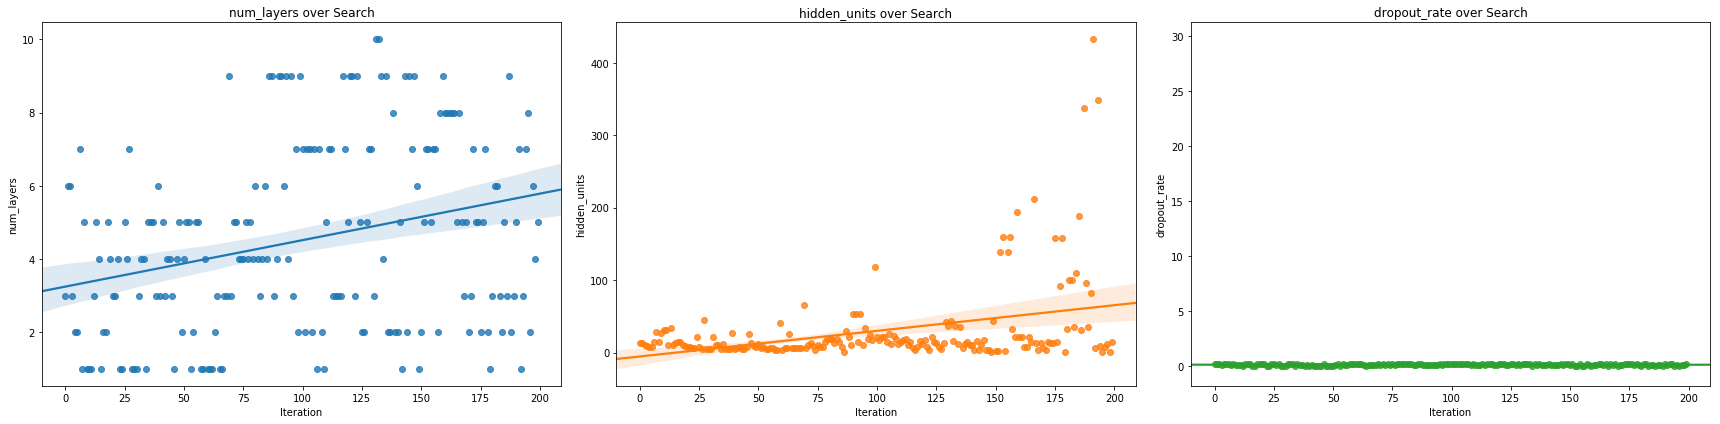

In [9]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(df=tuning_analysis, hyperparams=["num_layers", "hidden_units", "dropout_rate"])

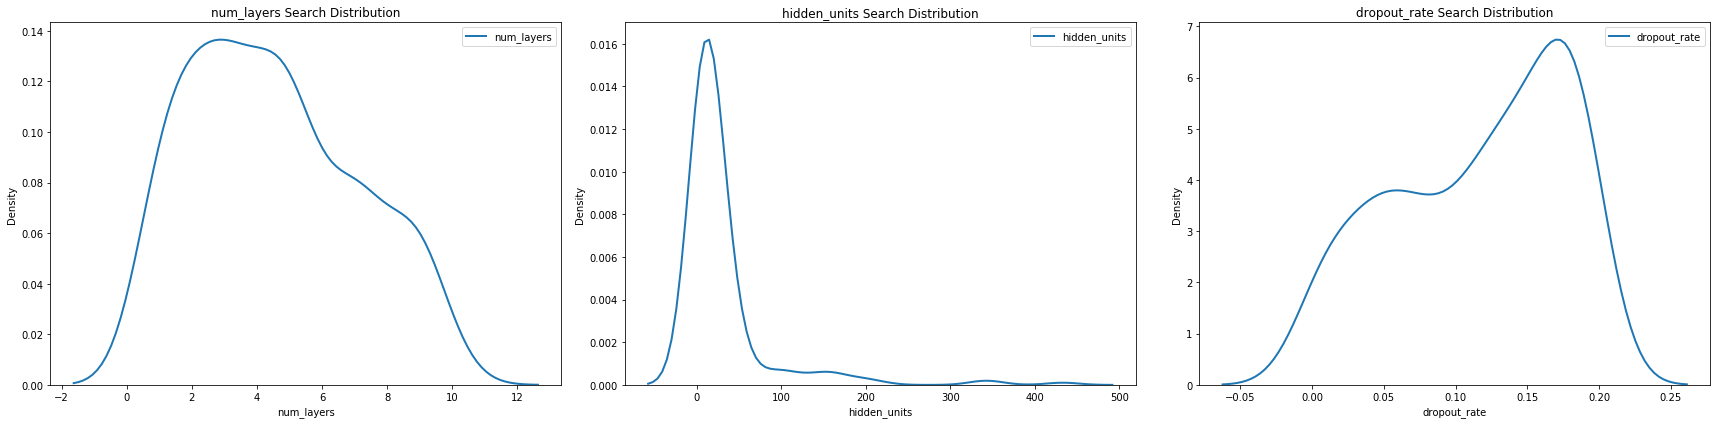

In [10]:
# Create a kde plot of hyperparameters used over the tuning window
plt_hyper.plot_search_dist(df=tuning_analysis, hyperparams=["num_layers", "hidden_units", "dropout_rate"])

In [11]:
# Get the best hyperparameters and refit the model over the training data with the best params
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)
batch_size = int(tuning_analysis["batch_size"].reset_index(drop=True)[0])
learning_rate = tuning_analysis["learning_rate"].reset_index(drop=True)[0]
num_layers = int(tuning_analysis["num_layers"].reset_index(drop=True)[0])
hidden_units = int(tuning_analysis["hidden_units"].reset_index(drop=True)[0])
dropout_rate = tuning_analysis["dropout_rate"].reset_index(drop=True)[0]
momentum = tuning_analysis["momentum"].reset_index(drop=True)[0]
initialization = tuning_analysis["initialization"].reset_index(drop=True)[0]
initialization = initialization.replace('"', '')

tf_estimator = TensorFlow(entry_point='train.py',
                  role=role,
                  train_instance_count=1,
                  train_instance_type='ml.m4.xlarge',
                  framework_version='2.0.0',
                  py_version='py3',
                  metric_definitions = [{'Name': 'val_accuracy', 'Regex': 'val_accuracy: ([0-9\\.]+)'},
                                        {'Name': 'accuracy', 'Regex': 'accuracy: ([0-9\\.]+)'}],
                  hyperparameters={'batch_size': batch_size,
                                   'learning_rate': learning_rate,
                                   'epochs':500,
                                   'num_layers': num_layers,
                                   'hidden_units': hidden_units,
                                   'dropout_rate': dropout_rate,
                                   'momentum': momentum,
                                   'initialization': initialization
                                }
                      )

tf_estimator.fit({"train": preprocessed_training_data, "test": preprocessed_test_data})

2020-03-01 01:25:00 Starting - Starting the training job...
2020-03-01 01:25:02 Starting - Launching requested ML instances...
2020-03-01 01:25:57 Starting - Preparing the instances for training......
2020-03-01 01:26:43 Downloading - Downloading input data...
2020-03-01 01:27:28 Training - Training image download completed. Training in progress..2020-03-01 01:27:33,157 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-03-01 01:27:33,166 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-01 01:27:33,680 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-01 01:27:33,698 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-01 01:27:33,715 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-01 01:27:33,728 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {}

2020-03-01 01:27:43.899910: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:27:45.310138: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#015      1/Unknown - 5s 5s/step - loss: 0.8160 - accuracy: 0.4916#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015      2/Unknown - 5s 2s/step - loss: 0.7684 - accuracy: 0.5028#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:27:49.876201: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:27:50.261247: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6971 - accuracy: 0.4777#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6949 - accuracy: 0.4953#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:28:10.861915: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:28:11.246226: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6348 - accuracy: 0.6341#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6450 - accuracy: 0.6145#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:28:27.105676: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:28:27.485793: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6276 - accuracy: 0.5726#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6520 - accuracy: 0.5531#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:28:47.805812: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:28:48.184717: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6397 - accuracy: 0.5363#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6278 - accuracy: 0.5251#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:29:08.502140: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:29:08.884053: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6040 - accuracy: 0.5670#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6403 - accuracy: 0.5540#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:29:29.551634: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6342 - accuracy: 0.6564#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6573 - accuracy: 0.6341#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

2020-03-01 01:29:50.365935: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6181 - accuracy: 0.6089#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6120 - accuracy: 0.6061#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

2020-03-01 01:30:13.292182: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:30:13.674354: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6118 - accuracy: 0.6648#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6381 - accuracy: 0.6052#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:30:29.391667: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:30:29.770405: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6202 - accuracy: 0.6034#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6323 - accuracy: 0.5987#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:30:50.607406: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6405 - accuracy: 0.5726#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6258 - accuracy: 0.5922#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

2020-03-01 01:31:11.448026: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6059 - accuracy: 0.6201#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6406 - accuracy: 0.5549#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

2020-03-01 01:31:27.348750: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
2020-03-01 01:31:27.732910: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6481 - accuracy: 0.5866#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6368 - accuracy: 0.5875#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

2020-03-01 01:31:48.473561: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
#011 [[{{node IteratorGetNext}}]]
#0151/4 [======>.......................] - ETA: 1s - loss: 0.6398 - accuracy: 0.5726#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0153/4 [=====================>........] - ETA: 0s - loss: 0.6283 - accuracy: 0.5745#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01


2020-03-01 01:32:32 Uploading - Uploading generated training model
2020-03-01 01:32:39 Completed - Training job completed
Training seconds: 356
Billable seconds: 356


In [12]:
training_job_description = tf_estimator.jobs[-1].describe()
training_job_description
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)
model_data_s3_uri

's3://sagemaker-us-east-2-800613416076/tensorflow-training-2020-03-01-01-25-00-527/output/model.tar.gz'

### Create the classification report on the validation dataset

Predict probabilities using the best model on the validation set and create the classification report

In [13]:
evaluate.tf_model_evaluate(model_data_s3_uri, preprocessed_valid_data, 'valid_df.csv')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Validation DataFrame shape: (29098, 62)
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


Classification report:
{'0.0': {'precision': 0.6844158200290276, 'recall': 0.5186636419880388, 'f1-score': 0.5901216221500919, 'support': 14547}, '1.0': {'precision': 0.6125926745601417, 'recall': 0.7609099030994433, 'f1-score': 0.6787432950191571, 'support': 14551}, 'accuracy': 0.6398034229156643, 'macro avg': {'precision': 0.6485042472945846, 'recall': 0.6397867725437411, 'f1-score': 0.6344324585846245, 'support': 29098}, 'weighted avg': {'precision': 0.6484993106566391, 'recall': 0.6398034229156643, 'f1-score': 0.6344385498398907, 'support': 29098}, 'roc_auc': 0.6397867725437411}
